# The COVID-19 pandemic

This notebook uses the NYT github repository to analyze the progression of COVID-19 throughout the US states. **The analyses contained herein are not meant to be used as primary literature on their own, and may have mistakes**. I make no claims as to the accuracy of my calculations.

The questions I am interested in asking regarding this pandemic are fairly straightforward:
    * What is the case fatality rate through time?
    * What do the case / death curves look through time?
    * Are the curves flattening?

I have used the 2019 population census projections to normalize data by population, and I also used the census bureau areas to compute population density.

To compute per-day difference, I was originally using a `savgol_filter` as implemented by scipy. As of April 26, 2020, I am using a Gaussian Kernel smoother with a 2 standard deviation bandwidth.

In [1]:
import datetime as dt
today = dt.datetime.now() 
print('This notebook was last updated on', today.strftime('%A %B %D at %H:%M'))

This notebook was last updated on Monday April 04/27/20 at 23:01


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from matplotlib import ticker
from matplotlib import dates as mdates
from scipy.signal import savgol_filter

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/covid_utils.py
import covid_utils as cv 

## Loading the data
You can find the spreadsheets I downloaded here: https://github.com/dangeles/dangeles.github.io/blob/master/data/

In [3]:
# load into a dataframe:
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)
density = pd.read_csv('../data/pop_density.csv', comment='#', thousands=',')

# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

# df.date = pd.to_datetime(df.date)
pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')
density.columns = np.append(np.array(['state']), density.columns[1:].values)

# calculate effective area per state:
density['EffArea'] = density['2010_POPULATION'].values/ density['2010_DENSITY'].values

# merge dfs:
df = df.merge(pop, left_on='state', right_on='state')
df = df.merge(density[['state', 'EffArea']], left_on='state', right_on='state')

df['density'] = df[2019] / df['EffArea']
df['normedCases'] = df.cases / df.density
df['normedPopCases'] = df.cases / df[2019]
df['normedDeaths'] = df.deaths / df.density
df['normedPopDeaths'] = df.deaths / df[2019]

# Case Fatality Rates
The plots below show the relationship between the number of cases and the number of deaths per state. The case fatality rate is defined as the fraction of COVID-19 infected individuals who pass away from the disease. In the graphs below, it's clear that as the number of cases has grown in New York, New Jersey and Massachusetts, so have the case fatality rate. The reason behind this relationship is unclear to me, but I suspect it has to do with decreasing quality of care as the system is overloaded.

An important point in the future will be the presence (or lack thereof) of hysteresis in the system. That is, as cases fall, will the death rate follow the same trajectory as it did before, falling back down to 1% initially? Unfortunately, I suspect that once the death rate is high, it will take a significant fall in the number of cases to bring it back down. I could very well be wrong about that, particularly if cheap and ample pharmacological supply becomes available.

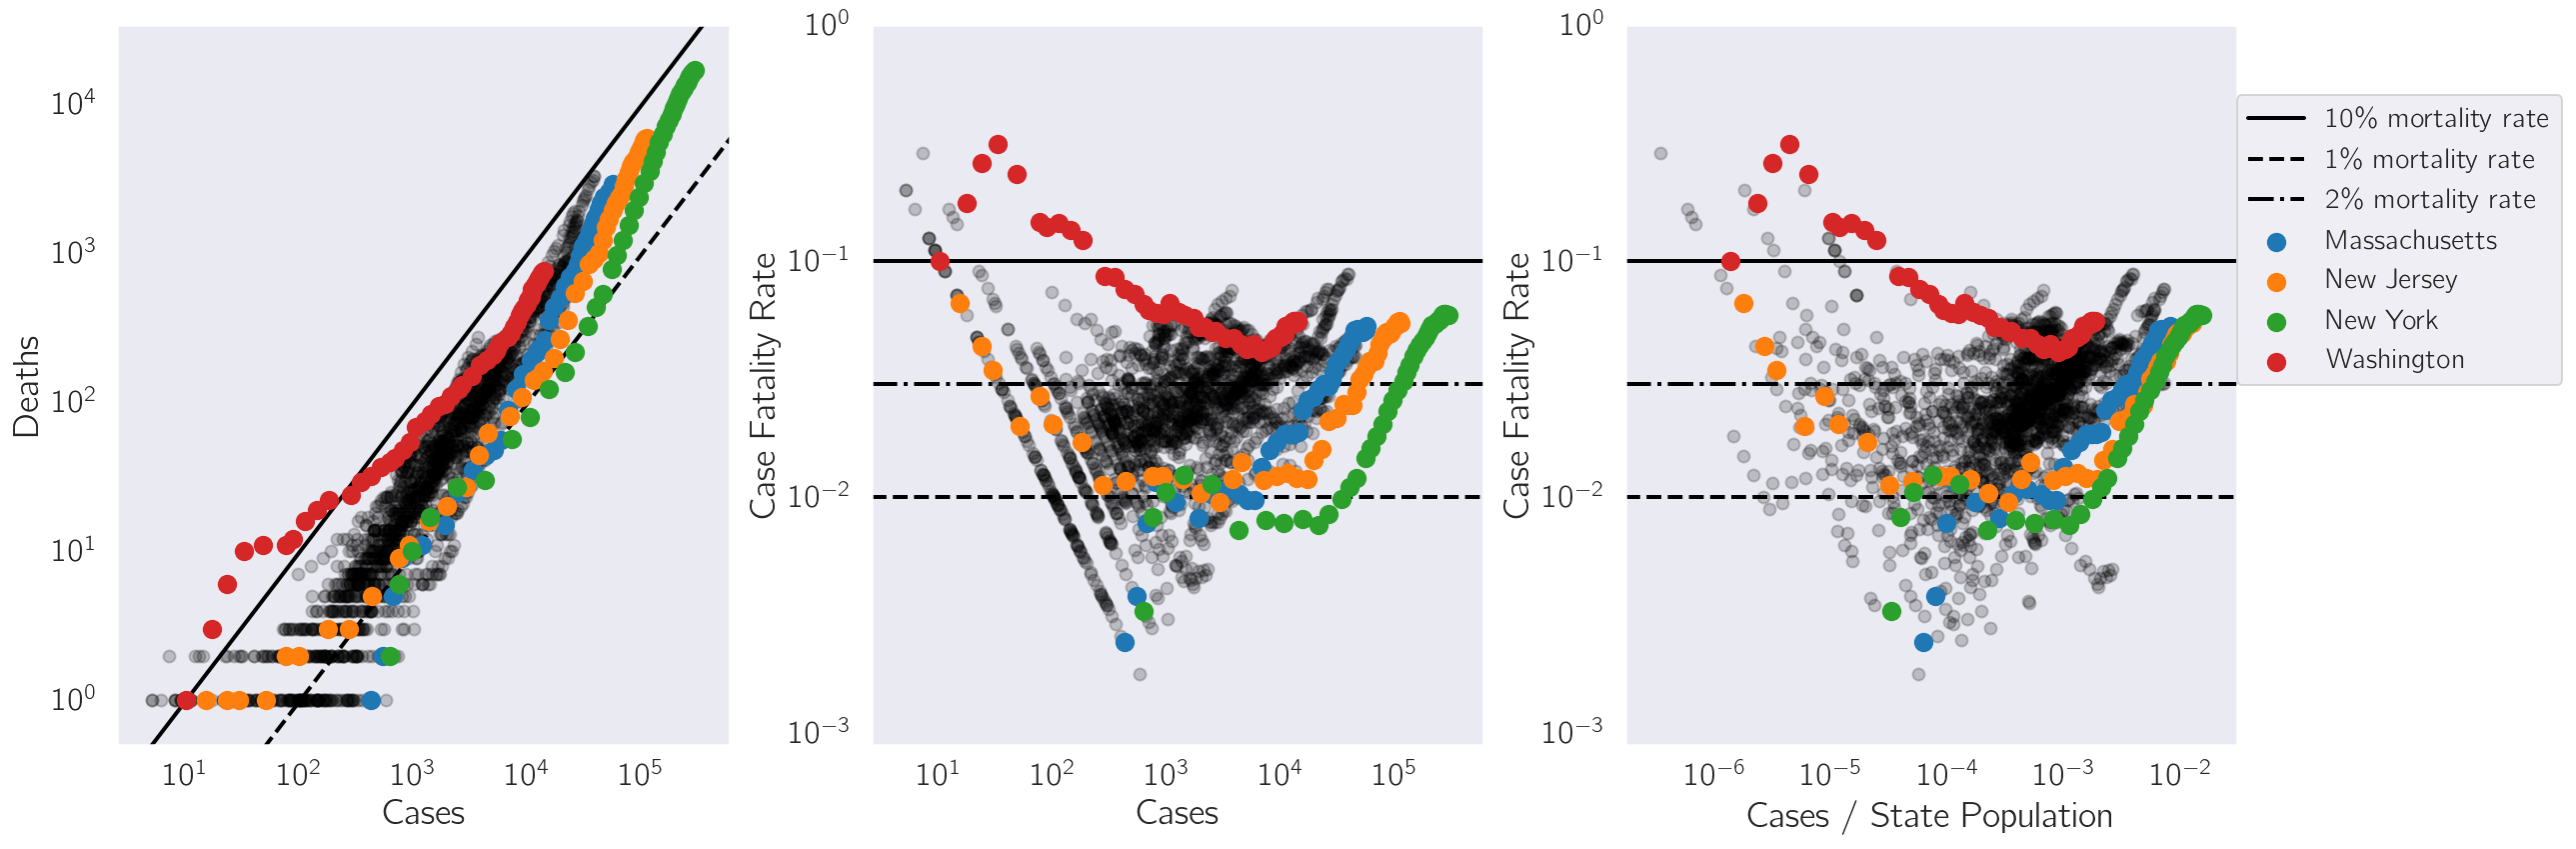

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

ax[0] = cv.plot_cases_vs_deaths(df, ax=ax[0])
ax[1] = cv.plot_cases_vs_deaths(df, CFR=True, ax=ax[1])
ax[2] = cv.plot_cases_vs_deaths(df, xcol='normedPopCases', ycol='normedPopDeaths', CFR=True, ax=ax[2])
_ = ax[2].legend(loc=(1, .5))
ax[2].set_xlabel('Cases / State Population')
plt.tight_layout()

# Epidemiological curves of COVID-19

I have plotted the cases and deaths through time in the plots below in *3 different ways*. The first column shows the absolute number of cases (first row) or deaths (second row). The second column shows the number of cases (deaths) normalized to the population of each state. The second column can be interpreted as your risk of getting COVID-19 through time for any given state, since it tells you the number of cases (or deaths) per million people for each state. Finally, the last column normalizes the number of cases (deaths) by the average population density of each state. This last column is quite interesting, and the units get funky ($infections \cdot km^2 / person$). The theory behind this is that the pandemic growth is directly dependent on the frequency of contacts between susceptible individuals and infected individuals, so normalizing by density should... do something? I mean, it is interesting that this kind of normalization drives California, Massachussets, Washington and New Jersey together. At any rate, it was an interesting idea, but I'm not sure what the results show. 

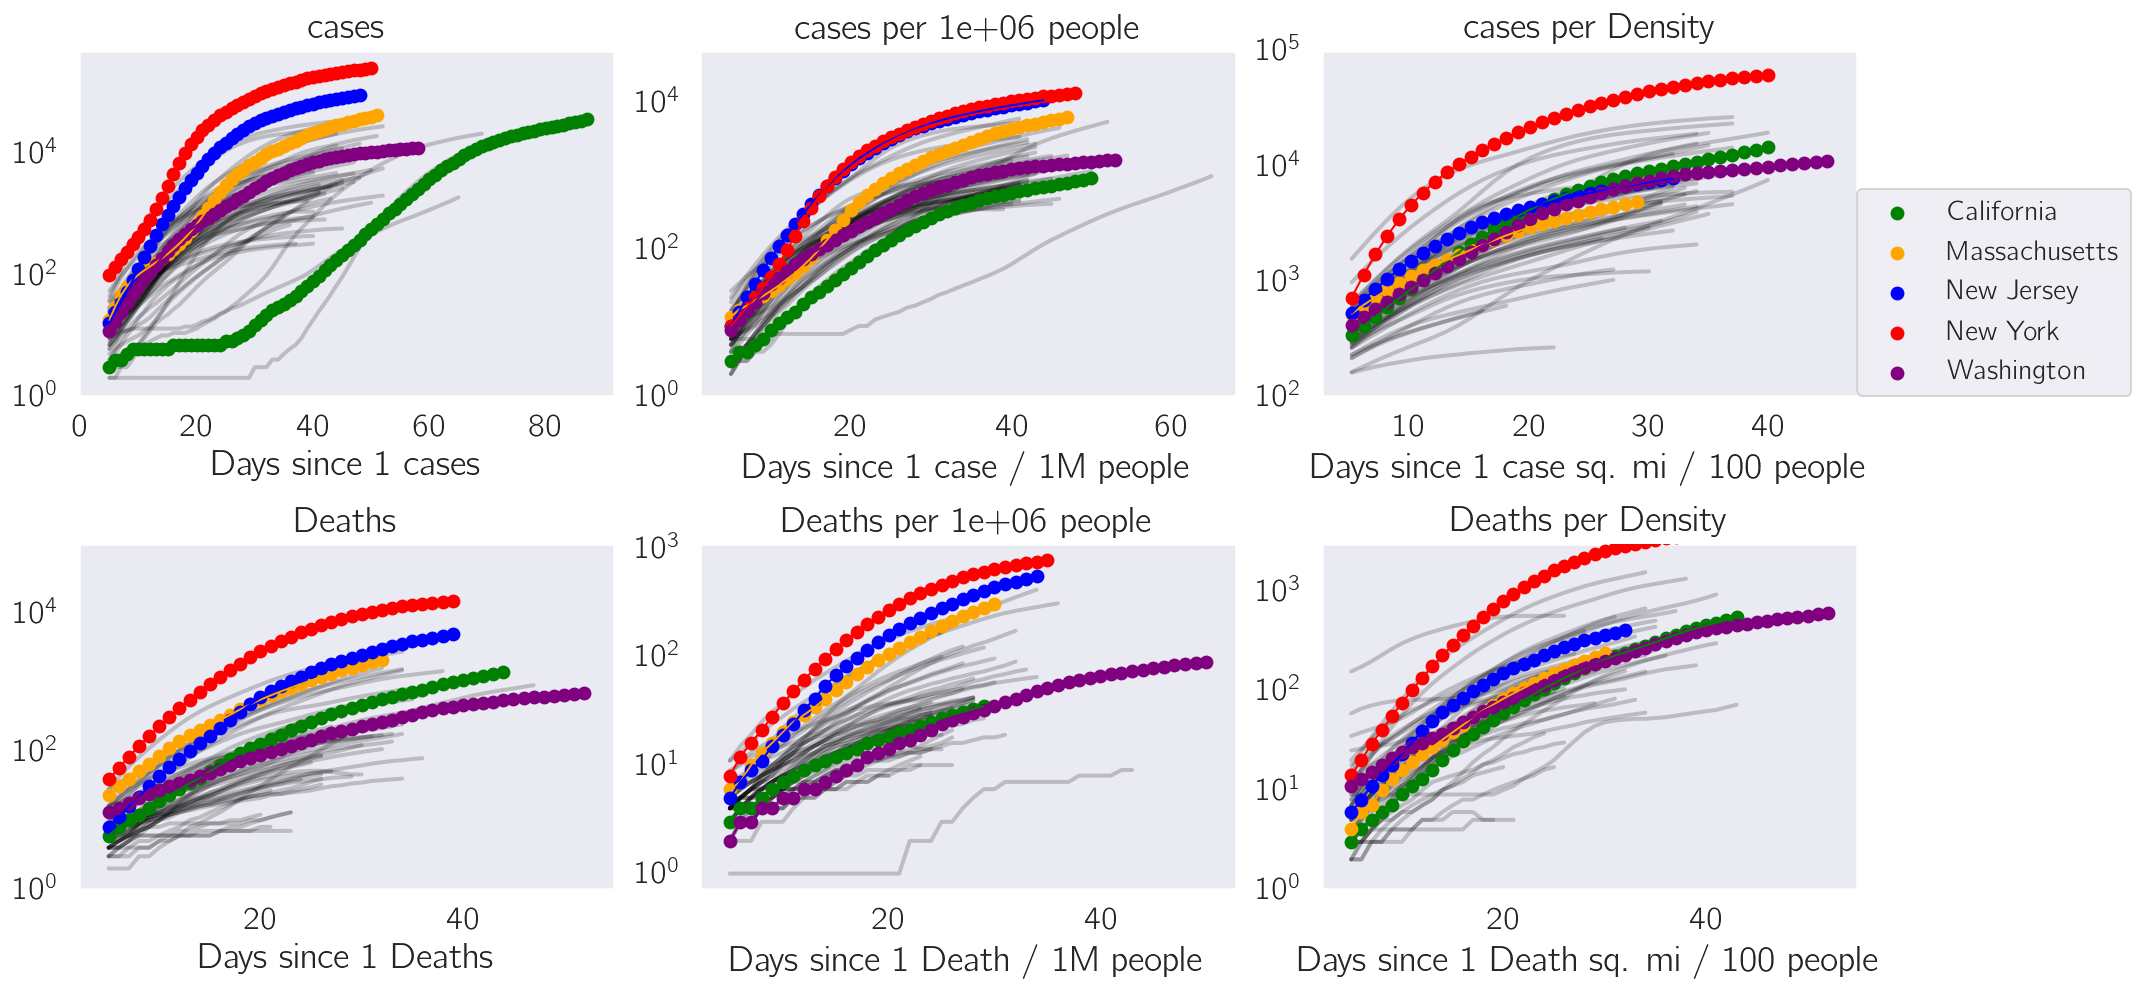

In [5]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 7))
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases', 'normedCases', n1=1, alpha=0.2, )
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths', 'normedDeaths', 1, 10 ** -6, 10 ** -2, ylab='Death', alpha=0.2)

# set y limits
ax[0, 0].set_ylim(1, 5 * 10**5)
ax[0, 1].set_ylim(1, 5 * 10 ** 4)
ax[0, 2].set_ylim(100, 1 * 10 ** 5)
ax[1, 0].set_ylim(1, 10**5)
ax[1, 2].set_ylim(1, 3 * 10 ** 3)
ax[0, 2].legend(loc=(1, 0))

for ai in ax:
    for aij in ai:
        aij.set_yscale('log')
plt.tight_layout()

# Are the curves flattening?

Notice that the case curves are on linear scale; the death curves are on log-scale.

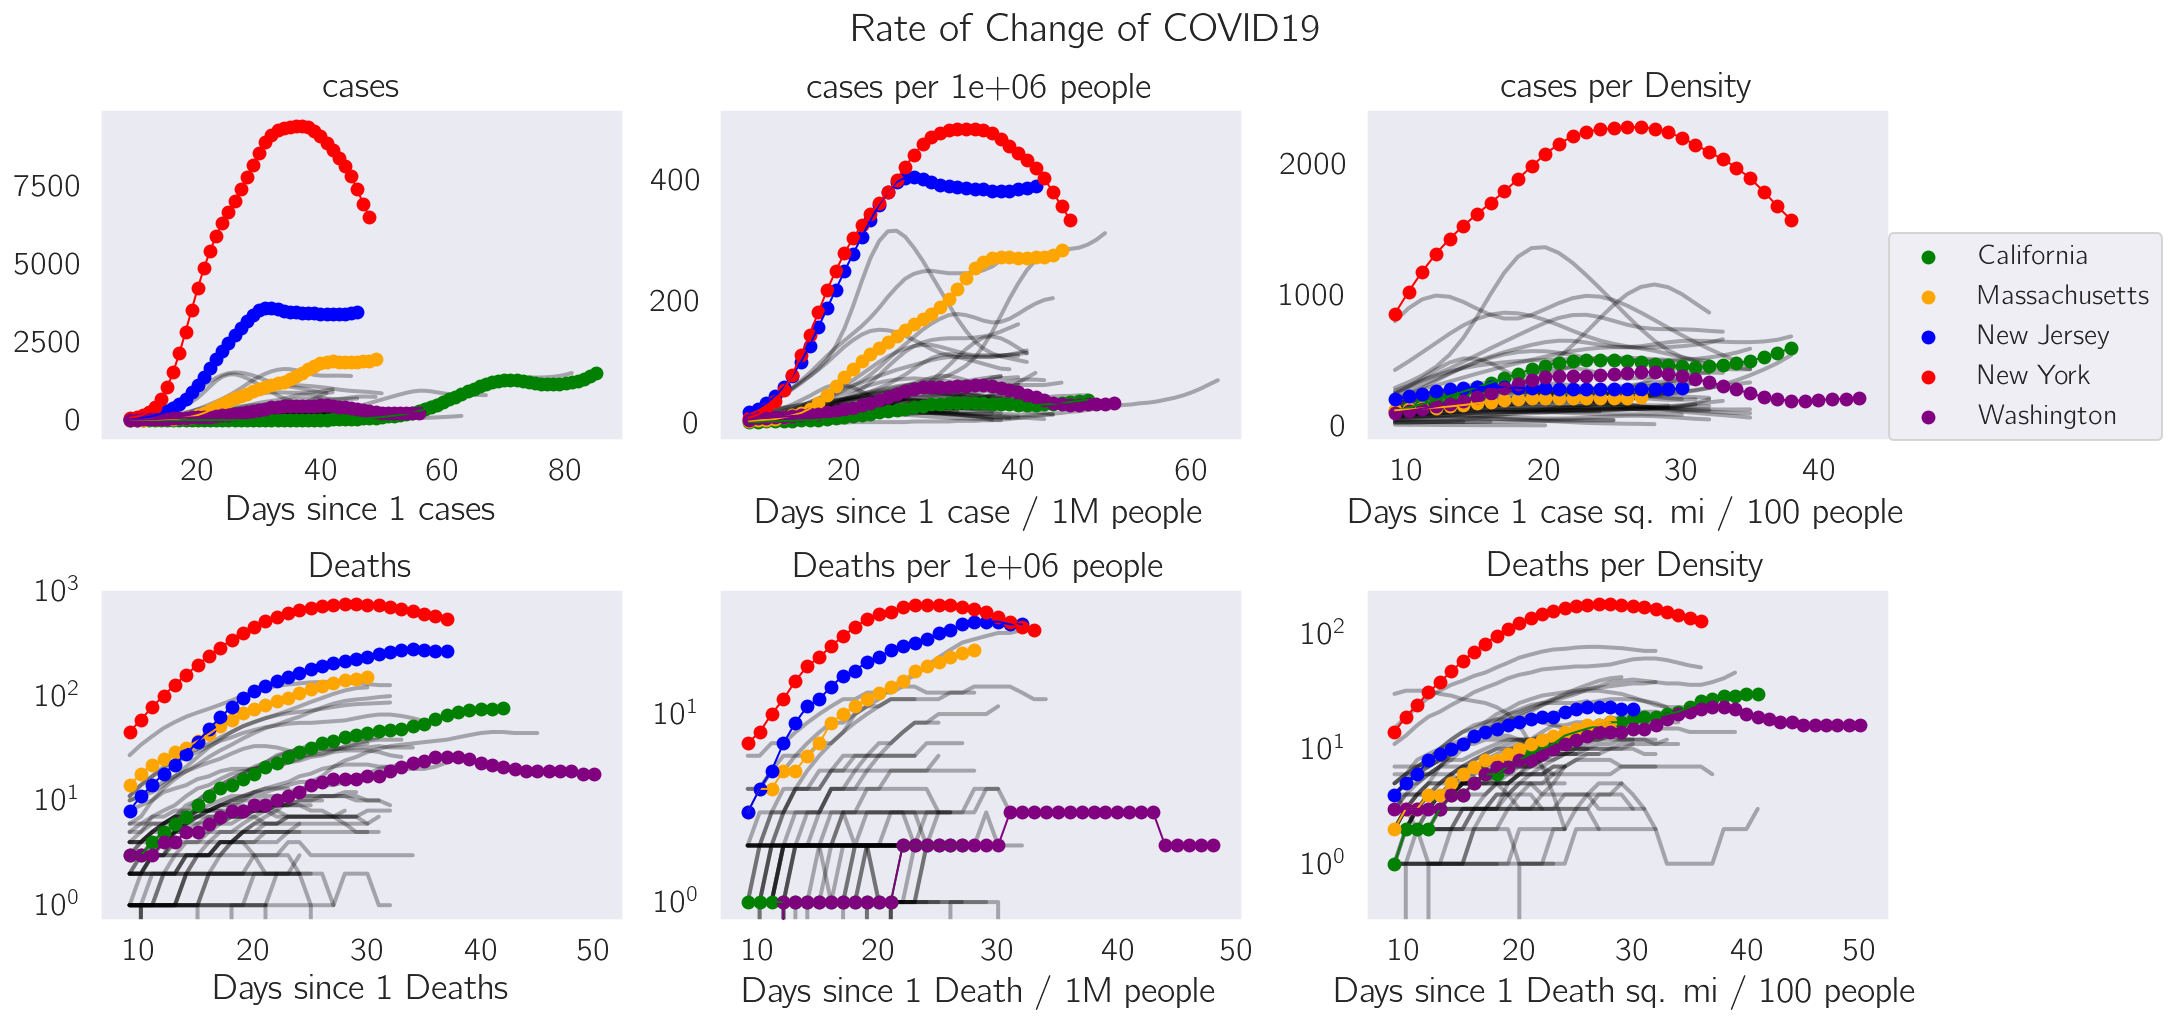

In [6]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 7), constrained_layout=True)

fig.suptitle('Rate of Change of COVID19', fontsize=20)
ax[0, :] = cv.plot(ax[0], df, 'cases', 'normedPopCases', 'normedCases', n1=1, gradient=True, window=8)
ax[1, :] = cv.plot(ax[1], df, 'deaths', 'normedPopDeaths', 'normedDeaths',
                   1, 10 ** -6, 10 ** -2, ylab='Death', gradient=True, window=8)
for ai in ax[1, :]:
    ai.set_yscale('log')
_ = ax[0, 2].legend(loc=(1, 0))        

# The viral reproductive viral, $R_t$, through time

Using this data, we can calculate the viral reproductive number through time. If we get $R_t < 1$, then that means the virus is dying out, whereas if it is above 1, the virus is growing.

I performed this analysis using the reported cases, but I also performed a second analysis using reported deaths. An $R_t$ based on deaths is meaningless from the point of view of quantitative interpretation, however, once we achieve $R_t < 1$ for a sufficient amount of time, we should see both curves dip below 1. This hasn't happened yet, but it is good to see all the curves are headed almost monotonically down. We are doing things right!

Here are the curves for four states:

./utils/covid_utils.py:274: RuntimeWarning: invalid value encountered in subtract
  p = np.exp(p - logsumexp(p)) * p_prev @ prior


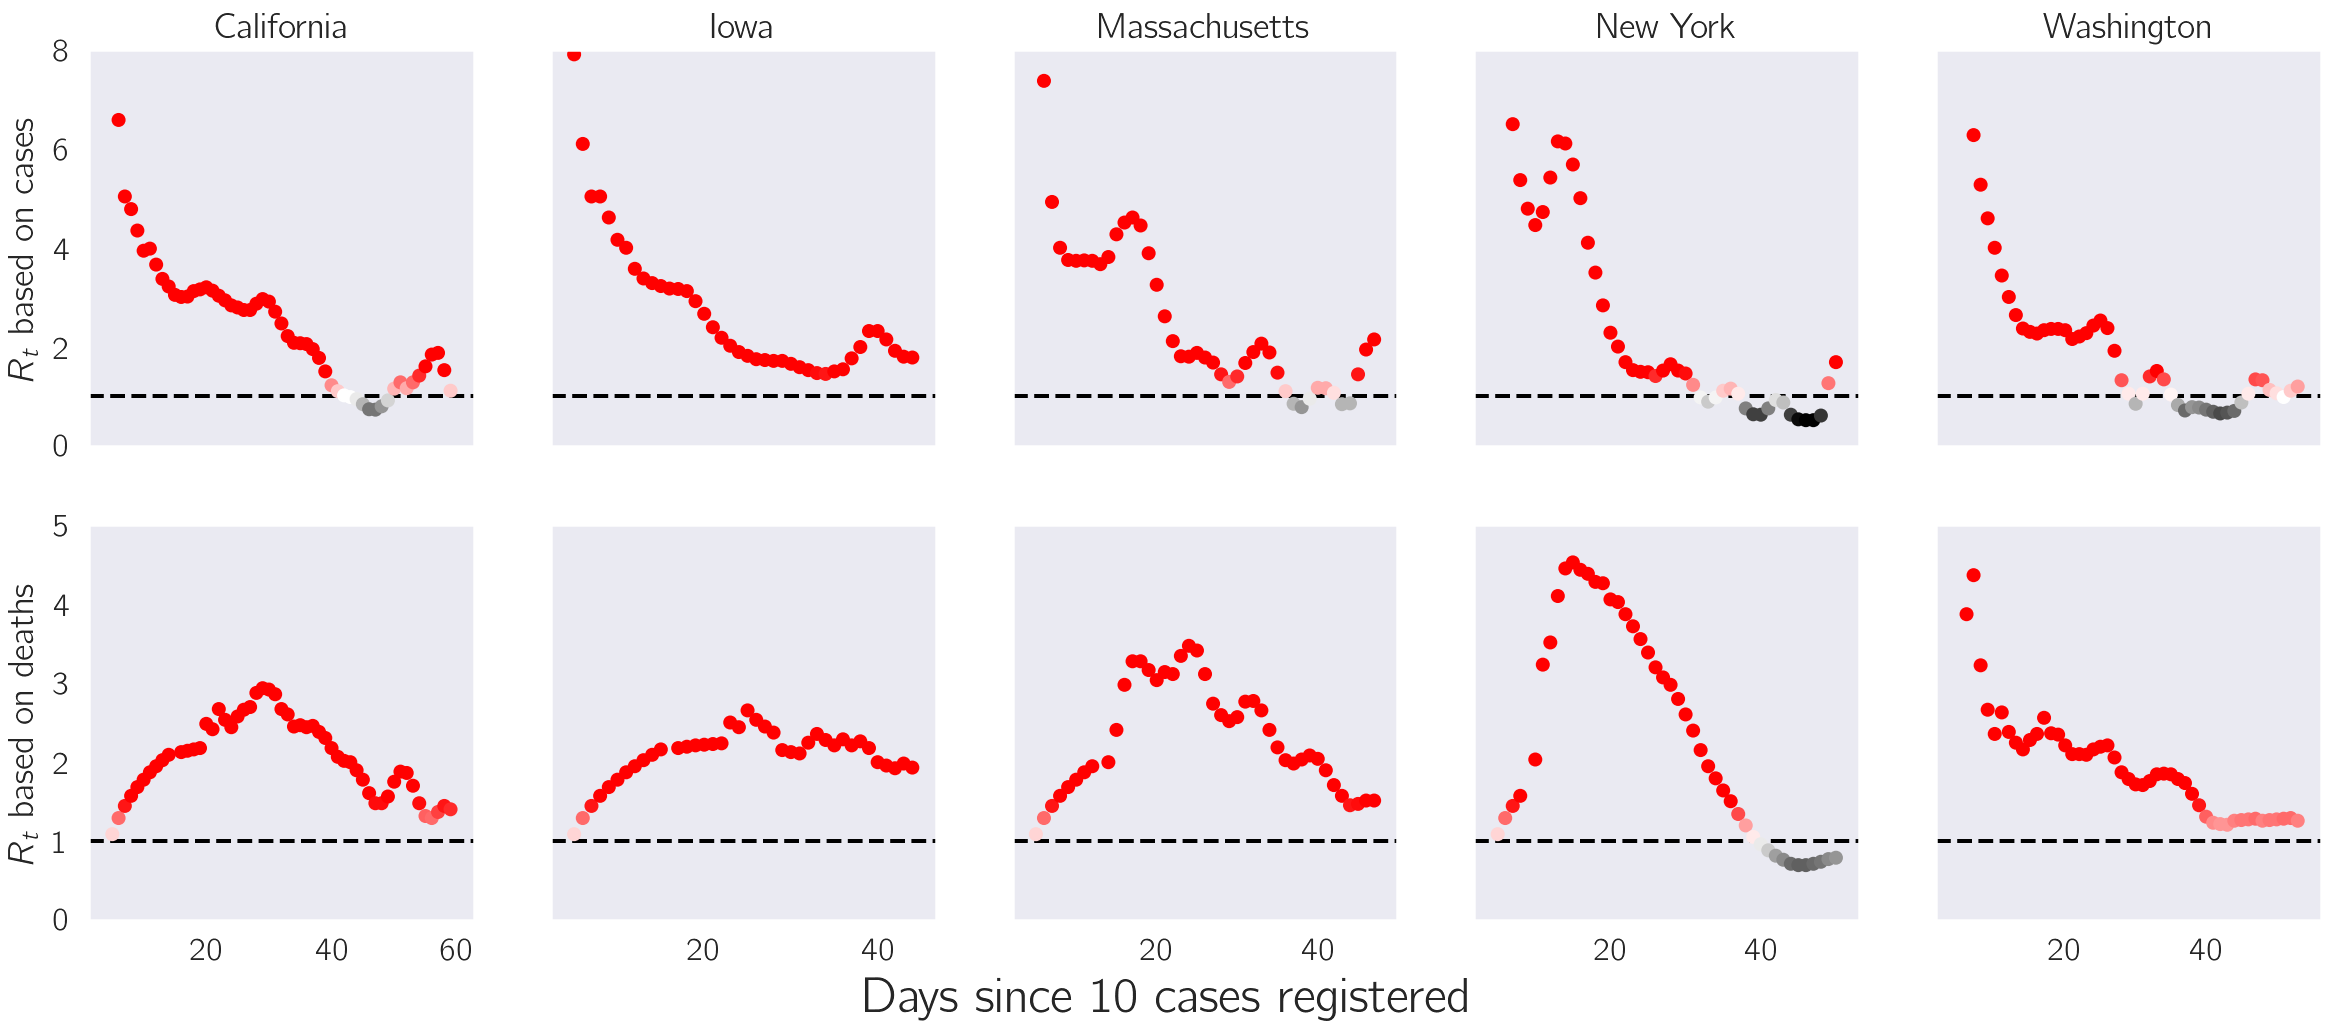

In [7]:
states = ['New York', 'California', 'Massachusetts', 'Washington', 'Iowa']
maxR = cv.plot_rt(states, df, df.cases > 10)
_ = plt.figtext(.5, .045, 'Days since 10 cases registered', fontsize=25, ha='center')

# What states have the highest and lowest # of deaths per capita?

In [8]:
for state, group in df.sort_values(['normedDeaths', 'state']).groupby('state'):
    if group.normedPopDeaths.max() > 10 ** -4:
        print(state, '{0:.0f}'.format(10 ** 6 * group.normedPopDeaths.max()))

Colorado 118
Connecticut 540
Delaware 123
District of Columbia 252
Illinois 153
Indiana 121
Louisiana 359
Maryland 137
Massachusetts 421
Michigan 332
New Jersey 669
New York 872
Pennsylvania 146
Rhode Island 213


In [9]:
for state, group in df.sort_values(['normedDeaths', 'state']).groupby('state'):
    if group.normedPopDeaths.max() < 2 * 10 ** -5:
        print(state, '{0:.0f}'.format(10 ** 6 * group.normedPopDeaths.max()))

Alaska 10
Arkansas 17
Hawaii 10
Montana 13
Puerto Rico 19
South Dakota 12
Utah 13
West Virginia 19
Wyoming 12


# What are the states with the best or worst $R_t$?

In [10]:
rt = np.array([])
s = np.array([], dtype=object)
for n, g in df[df.cases > 10].groupby('state'):
    gp = g.copy()
    gp['newCases'] = gp.cases.diff().rolling(window=8,
                                             win_type='gaussian',
                                             center=True).mean(std=2).round()
    gp['newDeaths'] = gp.deaths.diff().rolling(window=8,
                                               win_type='gaussian',
                                               center=True).mean(std=2).round()

    maxR = cv.r_calc(gp, gamma=1/10)
    seven_day_avg = np.mean(maxR[maxR > 0][-7:])
    s = np.append(n, s)
    rt = np.append(seven_day_avg, rt)

./utils/covid_utils.py:274: RuntimeWarning: invalid value encountered in subtract
  p = np.exp(p - logsumexp(p)) * p_prev @ prior


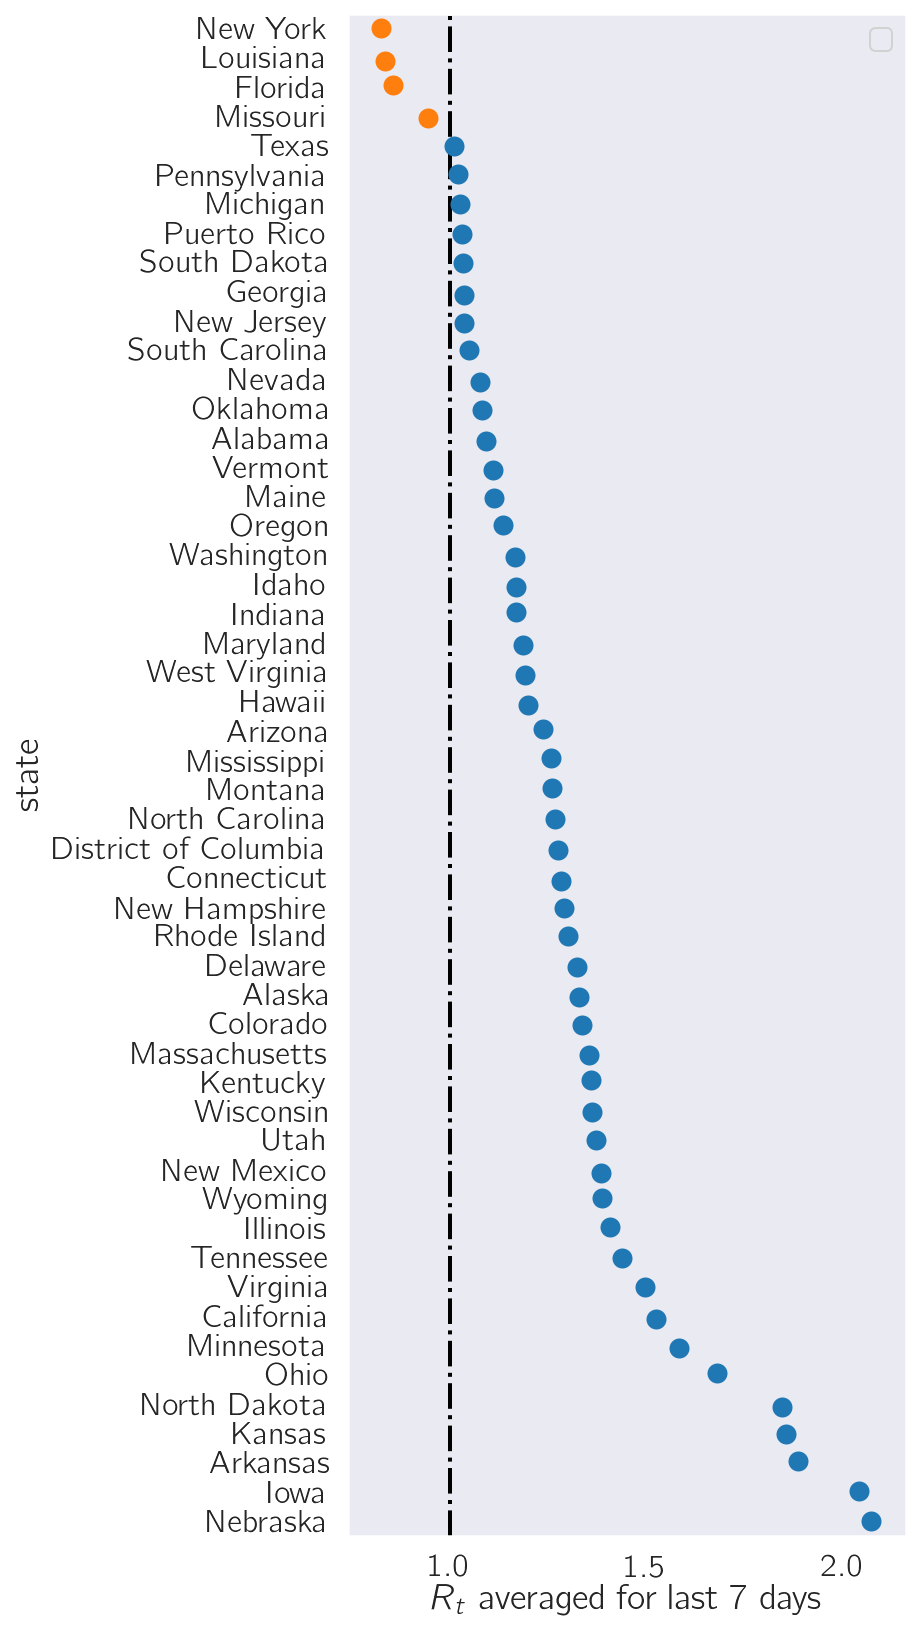

In [11]:
fig, ax = plt.subplots(figsize=(5, 14))
rdf = pd.DataFrame([s, rt]).transpose()
rdf.columns = ['state', 'r']
rdf['color'] = rdf.r < 1
sns.stripplot(y='state', x='r', hue='color', data=rdf.sort_values('r'), size=10)
plt.legend([])
plt.axvline(1, ls='-.', color='black')
_ = plt.xlabel(r'$R_t$ averaged for last 7 days')